### Create features without filtering things out
---

* Model Design Feedback:
    * Make the target less restrictive
        * ACH return in 3 days
        * Consider Indeterminate...this is what essentially make model look better
    * Candidates: 
        * Account balance < 0
        * Closed by risk, write off, charged off
    * Use more recent data, when Plaid is available.
        * Check availability of Plaid features
    * Drop Giact features



In [1]:
import pandas as pd
import numpy as np
import category_encoders
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
transactions_df = pd.read_parquet('../../artifacts/20201005/transactions_df_unlabeled_with_tmx_n_id.parquet')

<AxesSubplot:>

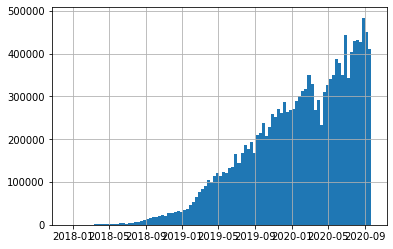

In [3]:
transactions_df.transaction_datetime.hist(bins=100)

In [4]:
transactions_df.shape, transactions_df.is_returned.value_counts()

((15295228, 206), False    644290
 True      42889
 Name: is_returned, dtype: int64)

### Segment by date
---
We do not need all the data for modeling purpose. After computing the aggregated features, we will limit dev data to the recent months, based on availability of Plaid and Quovo data.

In [5]:
def get_feature_by_source(df, source='plaid'):
    cols = df.columns[df.columns.str.contains(source)]
    return cols

#### Plaid

In [6]:
plaid_cols = get_feature_by_source(transactions_df, 'plaid')
plaid_cols

Index(['plaid_first_link_date', 'plaid_last_link_date', 'plaid_max_avail_bal',
       'plaid_min_avail_bal', 'plaid_total_pos_bal', 'plaid_total_neg_bal',
       'plaid_largest_checking_or_savings_balance', 'plaid_available_bal',
       'plaid_days_since_first_link'],
      dtype='object')

<AxesSubplot:>

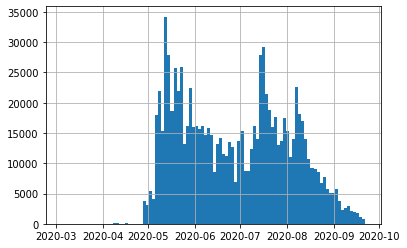

In [7]:
transactions_df[transactions_df.transaction_datetime >= pd.to_datetime("2020-05-01")]['plaid_first_link_date'].hist(bins=100)    

<AxesSubplot:>

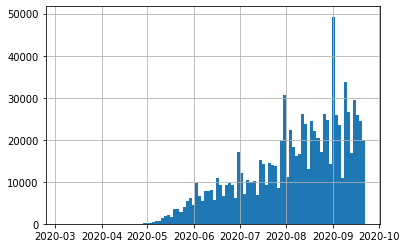

In [8]:
transactions_df[~transactions_df.plaid_first_link_date.isna()].transaction_datetime.hist(bins=100)

#### Quovo

In [9]:
quovo_cols = get_feature_by_source(transactions_df, 'quovo')
quovo_cols

Index(['quovo_first_link_date', 'quovo_last_link_date', 'quovo_max_avail_bal',
       'quovo_min_avail_bal', 'quovo_total_pos_bal', 'quovo_total_neg_bal',
       'quovo_largest_checking_or_savings_balance', 'quovo_available_bal',
       'quovo_days_since_first_link'],
      dtype='object')

<AxesSubplot:>

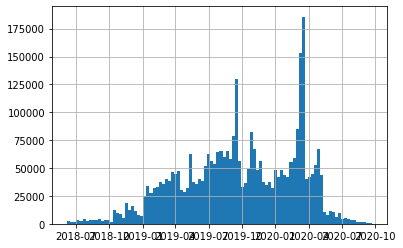

In [10]:
transactions_df[transactions_df.transaction_datetime >= pd.to_datetime("2020-05-01")]['quovo_first_link_date'].hist(bins=100)    

<AxesSubplot:>

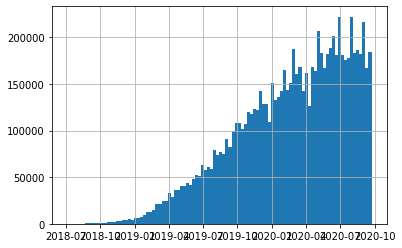

In [11]:
transactions_df[~transactions_df.quovo_first_link_date.isna()].transaction_datetime.hist(bins=100)

#### Okay we had Quovo for a long time. Just need to focus more on plaid

In [12]:
# when did we start to have plaid for most transactions?
transactions_df['transaction_date'] = transactions_df.transaction_datetime.dt.date

In [13]:
# tot_freq = transactions_df.transaction_date.value_counts().rename('total_freq').to_frame()
# tot_freq.index = pd.to_datetime(tot_freq.index)
# tot_freq.sort_index(inplace=True)

# plaid_freq = transactions_df[~transactions_df.plaid_first_link_date.isna()].transaction_date.value_counts().rename('plaid_freq').to_frame()
# plaid_freq.index = pd.to_datetime(plaid_freq.index)
# plaid_freq.sort_index(inplace=True)

# freq_ratio = plaid_freq.merge(tot_freq, left_index=True, right_index=True)
# freq_ratio['ratio'] = freq_ratio['plaid_freq'] / freq_ratio['total_freq']
# freq_ratio.index = pd.to_datetime(freq_ratio.index)
# freq_ratio.sort_index(inplace=True)

plaid_ratio = transactions_df.groupby('transaction_date')['plaid_first_link_date'].apply(lambda df_: (~df_.isna()).mean())

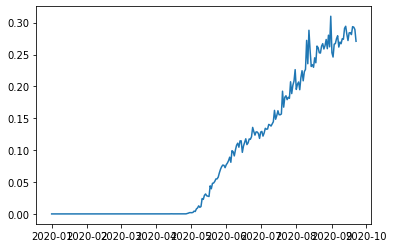

In [14]:
# plt.plot(freq_ratio.index, freq_ratio.ratio)
plaid_ratio = plaid_ratio.loc[pd.to_datetime('2020-01-01'):]
plt.plot(plaid_ratio.index, plaid_ratio.values)

#### ThreatMetrix

In [15]:
transactions_df.columns[transactions_df.columns.str.contains('tmx')]

Index(['tmx_created_dt', 'tmx_bb_bot_score', 'tmx_policy_score',
       'tmx_bb_fraud_score', 'tmx_input_ip_score', 'tmx_account_name_score',
       'tmx_summary_risk_score', 'tmx_account_email_score',
       'tmx_account_number_score', 'tmx_input_ip_worst_score',
       'tmx_account_address_score', 'tmx_digital_id_trust_score',
       'tmx_shipping_address_score', 'tmx_challenger_policy_score',
       'tmx_account_name_worst_score', 'tmx_account_email_worst_score',
       'tmx_account_number_worst_score', 'tmx_account_address_worst_score',
       'tmx_shipping_address_worst_score', 'tmx_digital_id_trust_score_rating',
       'tmx_digital_id_trust_score_reason_code', 'tmx_digital_id_confidence',
       'tmx_digital_id_confidence_rating', 'tmx_first_link_dt',
       'tmx_last_link_dt', 'nr_past_tmx', 'tmx_days_since_first_link'],
      dtype='object')

In [16]:
tmx_ratio = transactions_df.groupby('transaction_date')['tmx_first_link_dt'].apply(lambda df_: (~df_.isna()).mean())

(array([17897., 17956., 18017., 18078., 18140., 18201., 18262., 18322.,
        18383., 18444., 18506.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

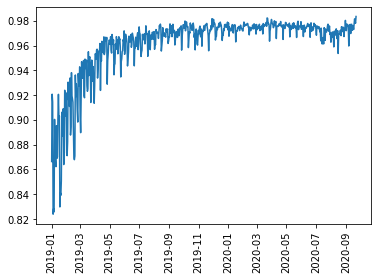

In [17]:
tmx_ratio = tmx_ratio.loc[pd.to_datetime('2019-01-01'):]
plt.plot(tmx_ratio.index, tmx_ratio.values)
plt.xticks(rotation=90)

#### Look at transactions by time
---

is_returned
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: transaction_datetime, dtype: object

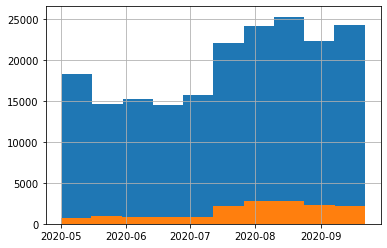

In [18]:
target_df = transactions_df[transactions_df.transaction_datetime >= pd.to_datetime("2020-05-01")]
target_df.groupby('is_returned')['transaction_datetime'].hist()

In [19]:
target_df.is_returned.value_counts()

False    196395
True      16394
Name: is_returned, dtype: int64

<AxesSubplot:>

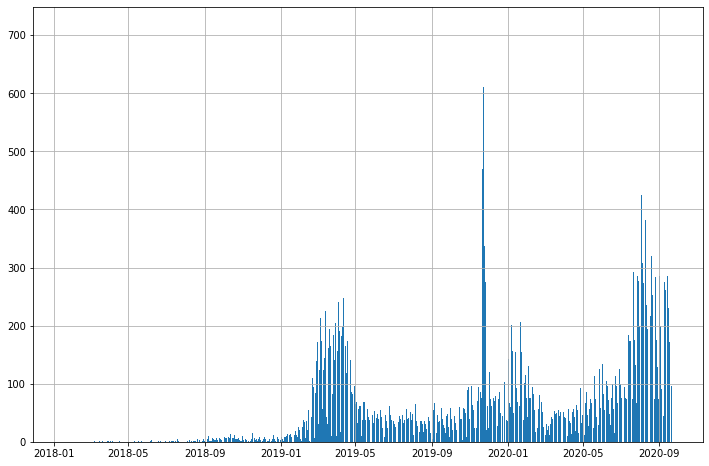

In [20]:
plt.figure(figsize=(12,8))
transactions_df[transactions_df.is_returned==True]['transaction_datetime'].hist(bins=1000)

### Current Only take data after May

In [21]:
modeling_df = transactions_df[transactions_df["transaction_datetime"].between(pd.to_datetime('2020-05-01'),
                                                    pd.to_datetime('2020-07-31'))]
test_df = transactions_df[transactions_df["transaction_datetime"] > pd.to_datetime('2020-08-01')]

In [22]:
def drop_non_ach(df):
    df = df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]
    return df

modeling_df = drop_non_ach(modeling_df)
test_df = drop_non_ach(test_df)

is_returned
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: transaction_datetime, dtype: object

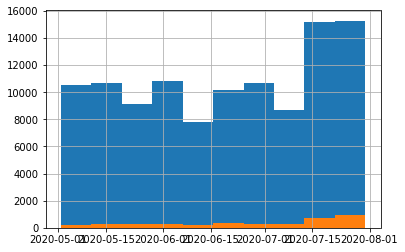

In [23]:
modeling_df.groupby('is_returned')['transaction_datetime'].hist()

is_returned
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: transaction_datetime, dtype: object

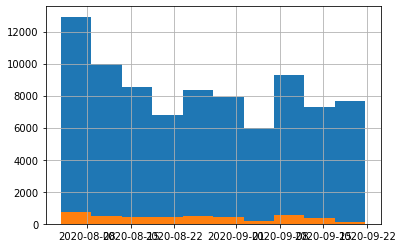

In [24]:
test_df.groupby('is_returned')['transaction_datetime'].hist()

In [25]:
modeling_df.shape, test_df.shape

((112599, 207), (88890, 207))

In [26]:
modeling_df.to_parquet('../../artifacts/20201005/modeling_df.parquet')
test_df.to_parquet('../../artifacts/20201005/test_df.parquet')

### All ACH Data

In [27]:
ach_df = drop_non_ach(transactions_df)

In [28]:
ach_df.to_parquet('../../artifacts/20201005/ach_df_full.parquet')